### Training a Random Forest Algorithm Model

In [25]:
# Data Processing
import pandas as pd
import numpy as np

#Model Algorithms
from lightgbm import LGBMClassifier
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

#SMOTE for rare classes in Offense Category
from imblearn.over_sampling import SMOTE

#Visualization
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("./Datasets/CT-Combined/combined_data.csv")

In [26]:
# Drop rare offense categories (< 50 rows)
classes = df['offense_category_name'].value_counts()
#common_classes = classes[classes >= 100].index
common_classes = classes[classes >= 250].index
df = df[df['offense_category_name'].isin(common_classes)]

##### One Hot Encoder for X

In [27]:
# Here, what I am doing is that I'm turning all features that aren't numerical into numerical format
# One hot encoder is best for nominal data where there's no ranks
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(df[['city', 'location_area']])

# X is the input features (what the model learns from)
numerical_features = df[['year', 'hour']]
X = pd.concat([numerical_features, ohetransform], axis = 1)

##### Label Encoder for y

In [28]:
le = LabelEncoder()
y = le.fit_transform(df["offense_category_name"])

##### Train Test Split for both X and y

In [29]:
#random_state is keeping the the result exact same everytime you run it, likes like a random_seed
#test_size is to give the model 20% of the dataset to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2, stratify=y)

In [30]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [31]:
print(X.shape, y.shape)

(366814, 143) (366814,)


##### Train the model on the data

In [32]:
model = LGBMClassifier(
    objective='multiclass',
    learning_rate=0.056,
    num_iterations=200,
    #num_class=len(le.classes_),
    #n_estimators=1500,
    #max_depth=10,
    #subsample=0.8,
    #colsample_bytree=0.8,
    #random_state=42,
    
)

In [33]:
#Random Forest (46.51%):
model.fit(X_train, y_train) 

#model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(10)])

LGBMClassifier(learning_rate=0.056, num_iterations=200, objective='multiclass')

In [34]:
y_prob = model.predict_proba(X_test)

# Calculate log loss
loss = log_loss(y_test, y_prob)
print(f"Log Loss: {loss:.4f}")

Log Loss: 1.5569


In [35]:
# Make predictions
y_pred = model.predict(X_test)

In [36]:
# Evaluate model 46.77%
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
target_names = le.inverse_transform(np.unique(y))
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 46.99%
                                          precision    recall  f1-score   support

                          Animal Cruelty       0.18      0.03      0.05        71
                                   Arson       0.00      0.00      0.00       103
                        Assault Offenses       0.42      0.61      0.50     13999
            Burglary/Breaking & Entering       0.38      0.11      0.17      2721
                  Counterfeiting/Forgery       0.48      0.15      0.23       894
Destruction/Damage/Vandalism of Property       0.33      0.18      0.24     10194
                  Drug/Narcotic Offenses       0.39      0.32      0.35      3749
                            Embezzlement       0.00      0.00      0.00       104
                     Extortion/Blackmail       0.18      0.01      0.03       135
                          Fraud Offenses       0.61      0.57      0.59      7036
                       Homicide Offenses       0.00      0.00      0.00        8

In [37]:
# Feature importance analysis
features_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(features_importance.head(10))


Top 10 Most Important Features:
                                              feature  importance
1                                                hour       29674
0                                                year       10636
132                      location_area_Residence/Home        3475
121  location_area_Highway/Road/Alley/Street/Sidewalk        2405
130             location_area_Parking/Drop Lot/Garage        2152
128                       location_area_Other/Unknown        1981
111                          location_area_Cyberspace        1886
36                                      city_Hartford        1686
49                                     city_New Haven        1675
113           location_area_Department/Discount Store        1448


In [38]:
print("\nClass Labels:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")


Class Labels:
0: Animal Cruelty
1: Arson
2: Assault Offenses
3: Burglary/Breaking & Entering
4: Counterfeiting/Forgery
5: Destruction/Damage/Vandalism of Property
6: Drug/Narcotic Offenses
7: Embezzlement
8: Extortion/Blackmail
9: Fraud Offenses
10: Homicide Offenses
11: Kidnapping/Abduction
12: Larceny/Theft Offenses
13: Motor Vehicle Theft
14: Pornography/Obscene Material
15: Robbery
16: Sex Offenses
17: Sex Offenses, Non-forcible
18: Stolen Property Offenses
19: Weapon Law Violations


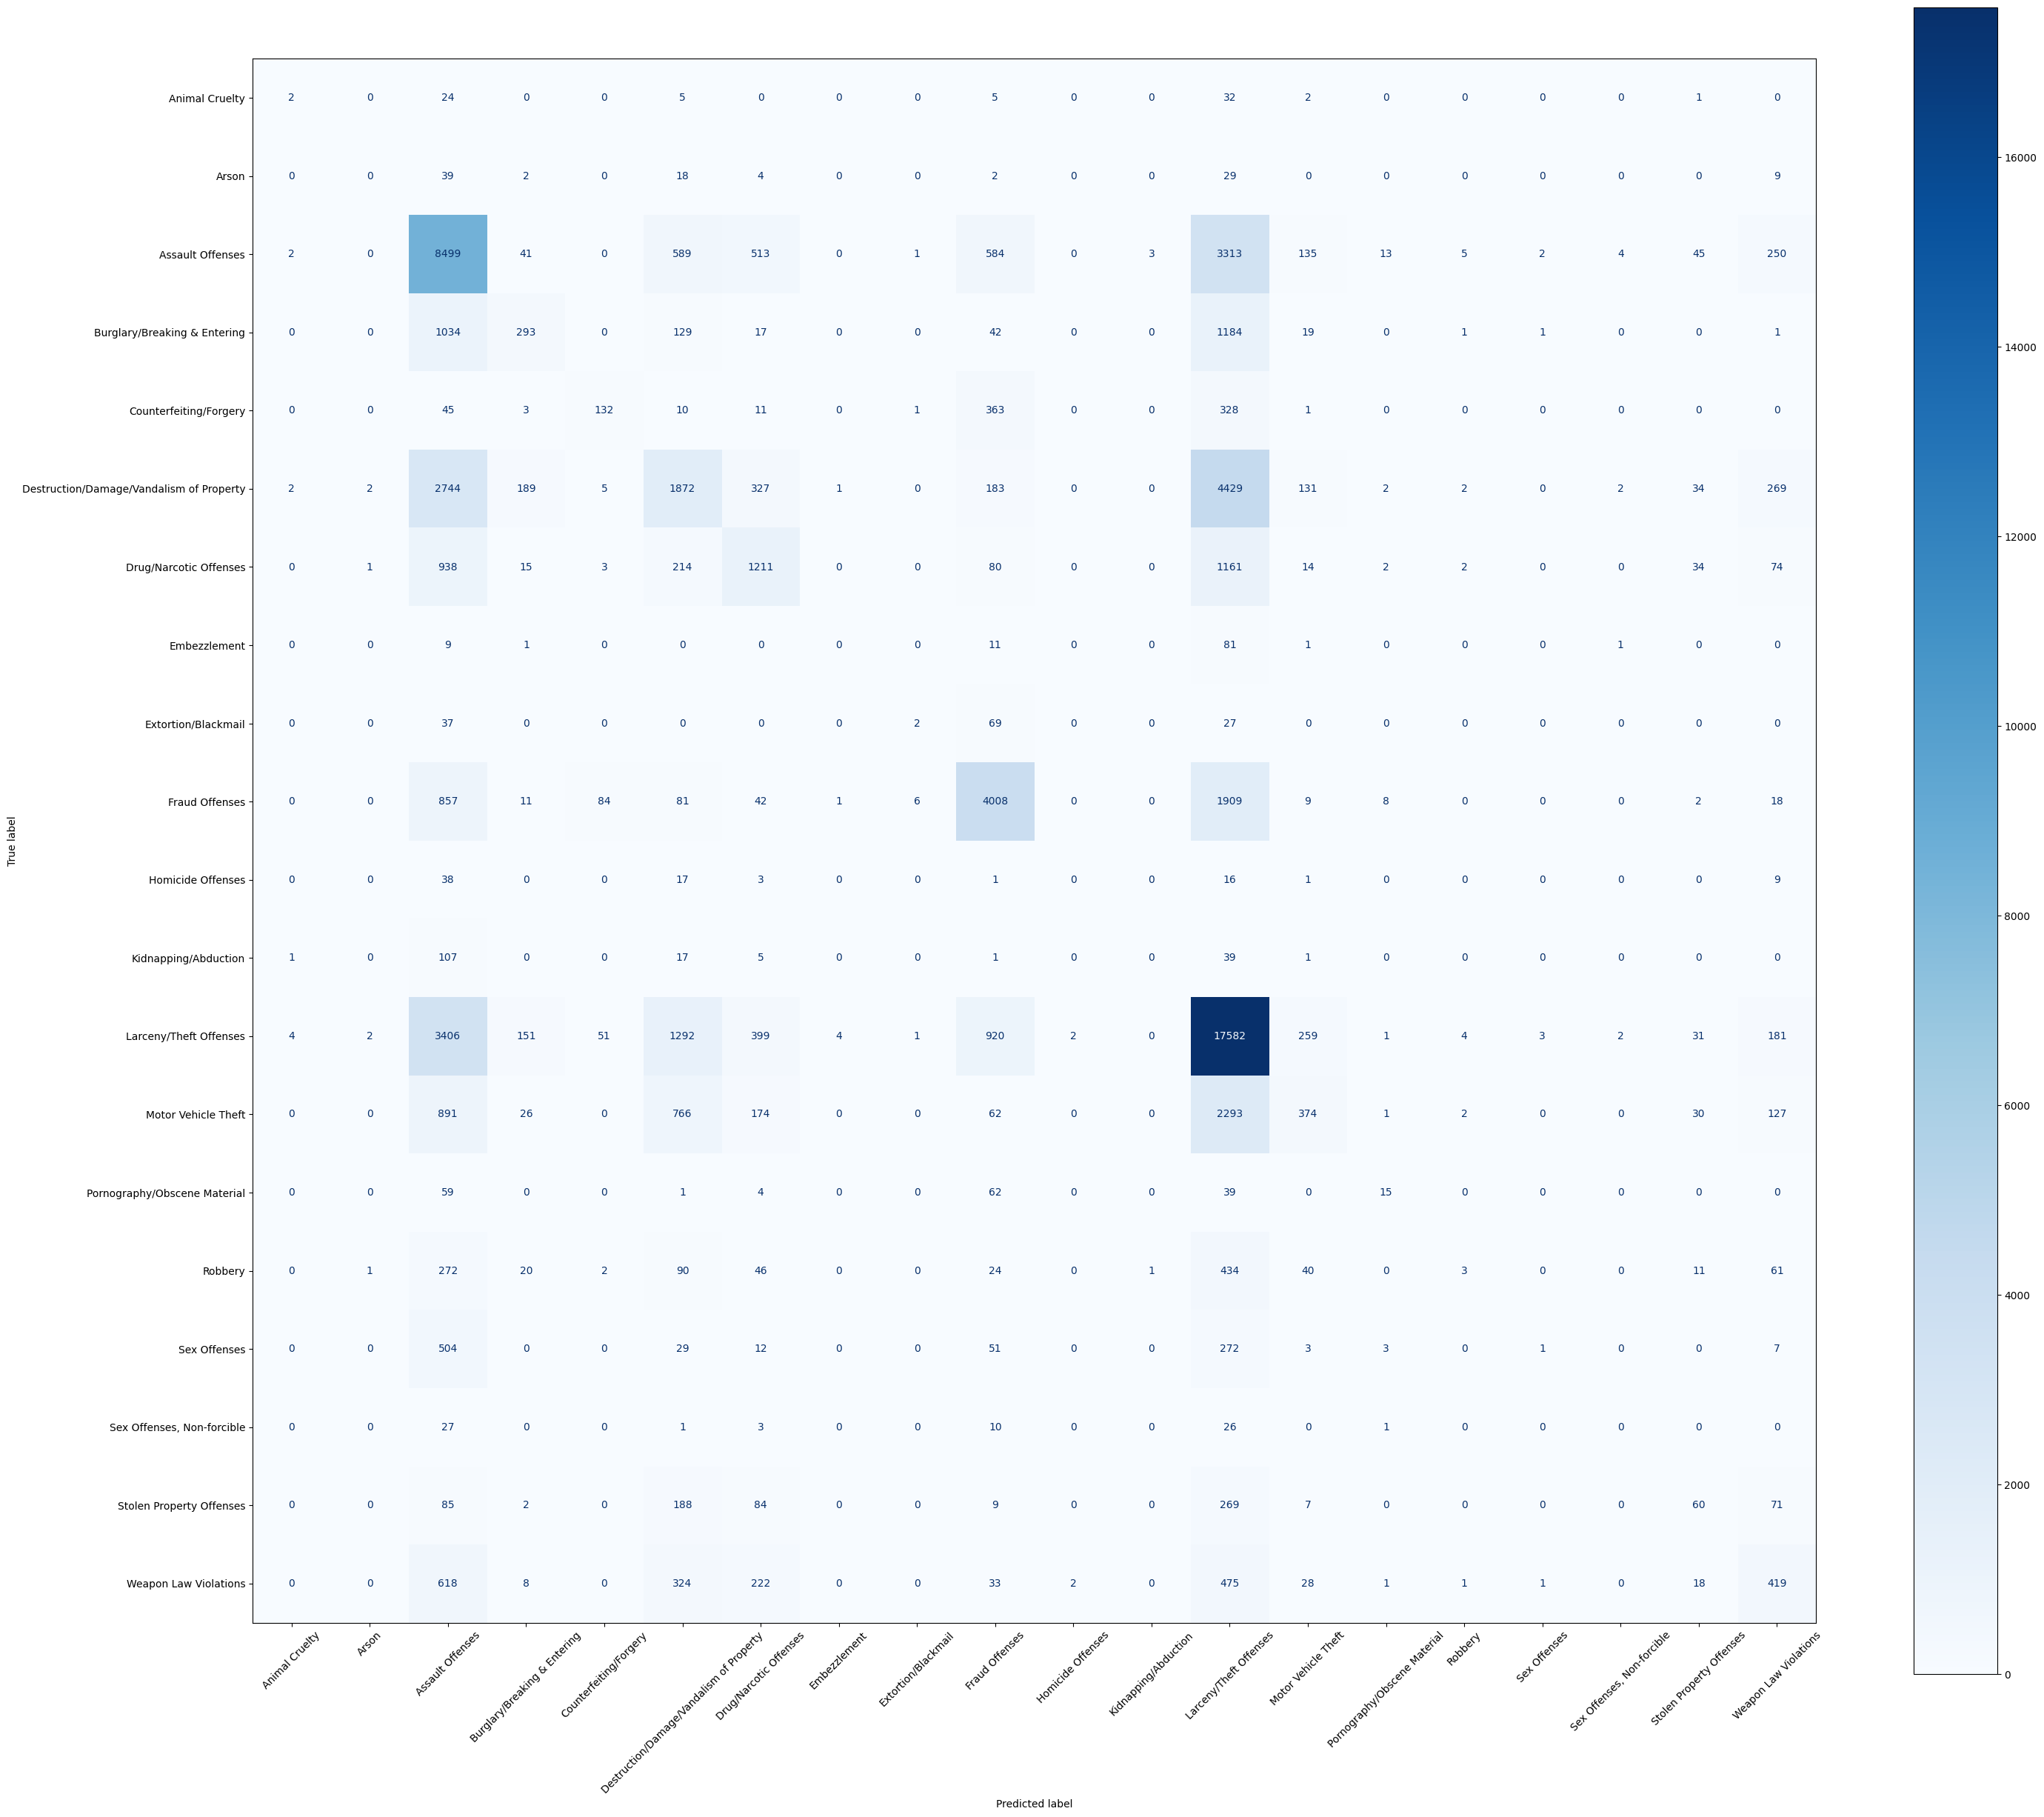

In [39]:
# Compute the matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with larger figure
fig, ax = plt.subplots(figsize=(30, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

plt.tight_layout()
plt.show()

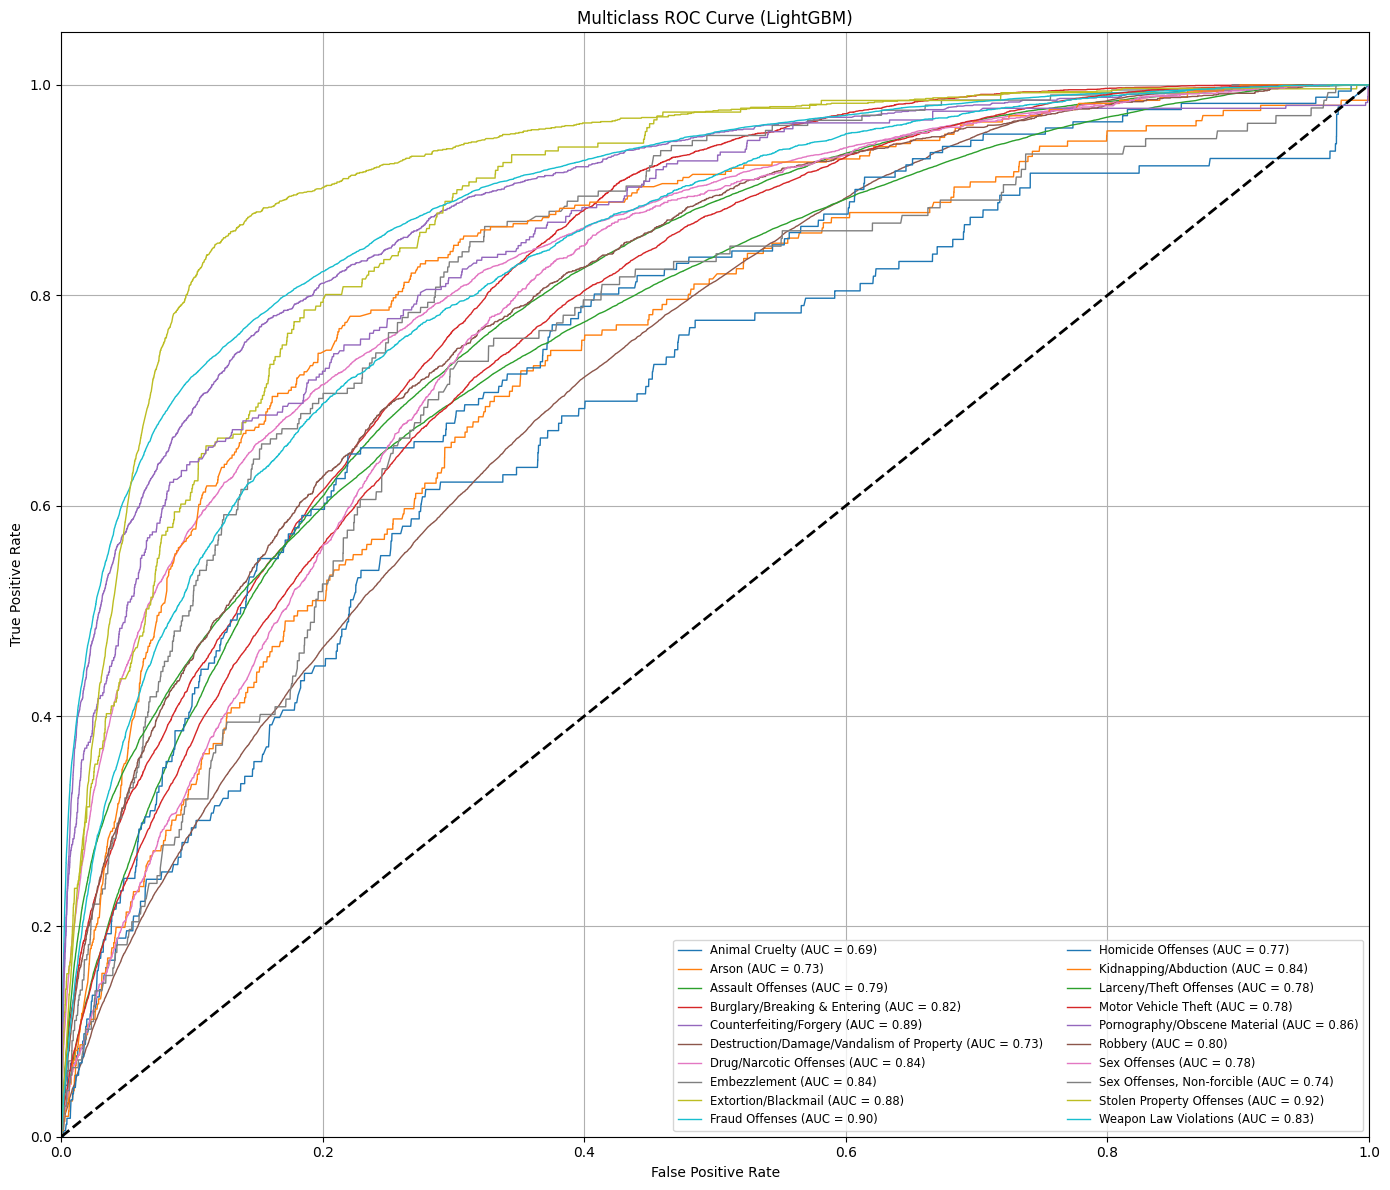

In [40]:
# Binarize the target
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Train/test split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.4, random_state=42, stratify=y
)

# One-vs-Rest with LightGBM
clf = OneVsRestClassifier(LGBMClassifier(random_state=42, verbose=-1))
clf.fit(X_train, y_train_bin)
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(14, 12))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (LightGBM)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
print(df.shape)

(366814, 11)


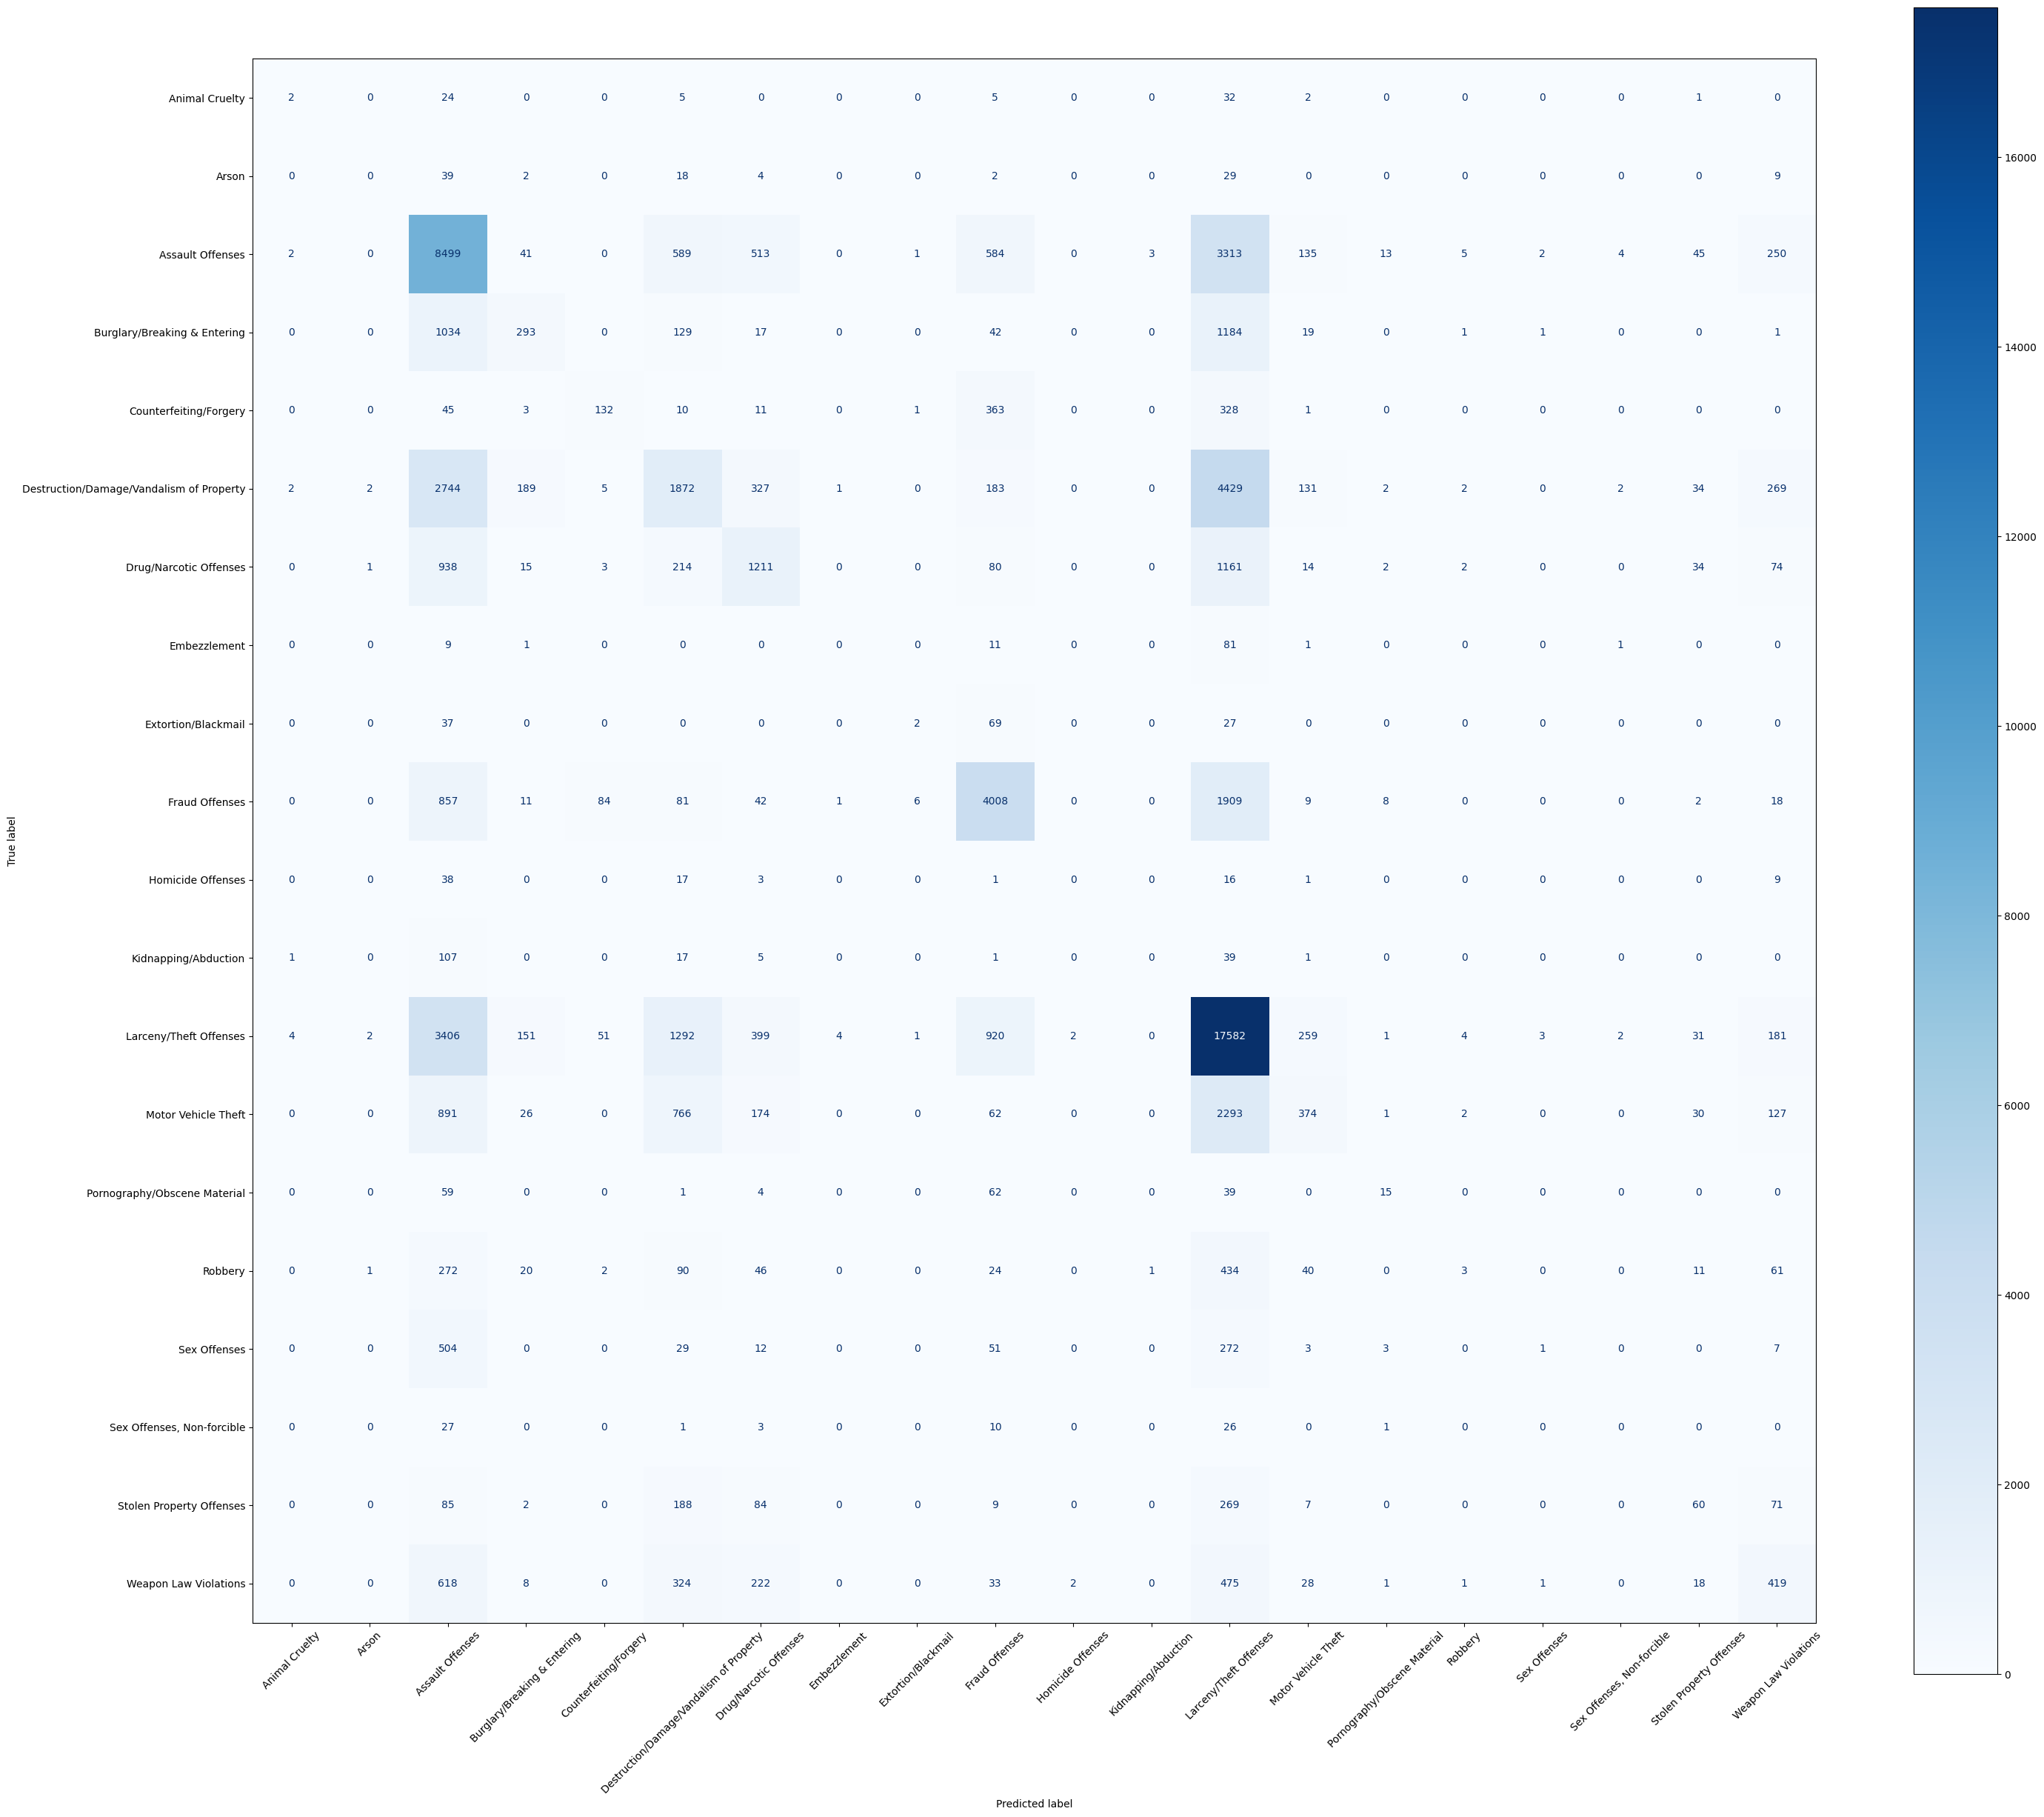

In [42]:
cm = confusion_matrix(y_test, y_pred)

# Plot with larger figure
fig, ax = plt.subplots(figsize=(30, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

plt.tight_layout()
plt.show()

In [43]:
df

,year,month,day,hour,date,dayofweek,city,population,offense_category_name,location_area,crime_rate_per_1000_people
0,2022,9,22,13,2022-09-22,3,Berlin,20109,Drug/Narcotic Offenses,Abandoned/Condemned Structure,120
1,2022,6,4,20,2022-06-04,5,Norwich,40096,Weapon Law Violations,Abandoned/Condemned Structure,166
2,2022,7,10,20,2022-07-10,6,Norwich,40096,Drug/Narcotic Offenses,Abandoned/Condemned Structure,166
3,2022,7,10,20,2022-07-10,6,Norwich,40096,Drug/Narcotic Offenses,Abandoned/Condemned Structure,166
4,2022,10,14,13,2022-10-14,4,Bridgeport,148395,Drug/Narcotic Offenses,Abandoned/Condemned Structure,106
...,...,...,...,...,...,...,...,...,...,...,...
366985,2021,3,13,16,2021-03-13,5,Stratford,51683,Assault Offenses,Other/Unknown,99
366986,2021,9,5,17,2021-09-05,6,Stratford,51683,Assault Offenses,Other/Unknown,99
366987,2021,12,3,14,2021-12-03,4,Stratford,51683,Larceny/Theft Offenses,Other/Unknown,99
366988,2021,10,27,11,2021-10-27,2,Stratford,51683,Larceny/Theft Offenses,Other/Unknown,99
